In [58]:
from __future__ import annotations
from typing import Final as const, Any

In [59]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import DataLoader

## CNNモデルの作成

### 1. アノテーション付き画像データのロード
ここではCOCO形式でエクスポートされたアノテーション付き画像データを教師データとして使用します。

In [60]:
#1.学習データ（COCO形式）のロード
from torchvision.datasets import CocoDetection
import torchvision.transforms as transforms

img_folder_path: str = "./TrainDataSet/"
anno_file_path: str = "./TrainDataSet/result.json"

#Transformsの定義
transform = transforms.Compose([
    transforms.ToTensor()
])

#COCOデータセットのロード
coco_dataset = CocoDetection(img_folder_path, anno_file_path, transform=transform)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### 2.モデルの準備
今回は少ないデータセットで学習させるため、FRCNNの事前学習済みモデルをファインチューニングして学習させます。その際、CUDAが使用可能な場合はGPUを使って計算をするよう設定を行います。

In [61]:
#2.モデル準備
model = fasterrcnn_resnet50_fpn(pretrained=True)
data_loader: DataLoader = DataLoader(coco_dataset, batch_size=4, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
#CUDAが使えるならGPUを使う
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    model.to(device)
    print(f"Using device: {device}")
else:
    print("Using CPU")


/Users/s.takabayashi/OCR-Sample/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/s.takabayashi/OCR-Sample/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using CPU


### 3.ファインチューニングによるモデルの再学習

In [62]:
#3.ファインチューニング
model.train()
for images, targets in data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k: (v.to(device) if torch.is_tensor(v) else v) for k, v in t.items()} for target_list in targets for t in target_list]


### 4.モデルの保存

In [63]:
import os

save_path = "./Models/Model_F-RCNN-0.1.pth"
if os.path.exists(save_path) is False:
    os.makedirs(os.path.dirname(save_path))


torch.save(model.state_dict(), save_path)

## CNN利用した紙面検知の検証

In [64]:
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

### 1.保存したモデルの読み込みと推論モードへの切り替え

In [65]:
#保存したモデルの読み込み
model_path: const[str] = "./Models/Model_F-RCNN-0.1.pth"
model = fasterrcnn_resnet50_fpn(pretrained=False) #Fast-RCNNを指定
model.load_state_dict(torch.load(model_path))
"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == torch.device("cuda"):
    model.to(device)
    print(f"Using device: {device}")
else:
    print("Using CPU")
"""
#model.to(device) #GPUにモデルを転送
#学習モードから評価モードへの切り替え
model.eval()

/Users/s.takabayashi/OCR-Sample/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

### 2.モデルを使って入力画像から紙面を特定する

In [66]:
def prediction(img_path: str, plot_title: str="") -> tuple(list[tuple[int, int]], np.ndarray[Any, Any, Any]):
    #入力画像の指定
    img = Image.open(img_path)

    #Tensorに変換
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_tensor = transform(img).unsqueeze(0)

    #推論
    with torch.no_grad():
        pred = model(img_tensor)

    #推論結果の描画
    #スコアが最大のものを抽出
    image_np = img_tensor[0].numpy().transpose((1, 2, 0))
    #image_np_rotated = np.rot90(image_np, -1)  # 90度回転
    fig, ax = plt.subplots(1, figsize=(10, 20))
    ax.imshow(image_np)

    # スコアが最大のバウンディングボックスと信頼度の描画
    max_score_idx = pred[0]['scores'].numpy().argmax()
    box = pred[0]['boxes'].numpy()[max_score_idx]
    print("box", box[0])
    
    score = pred[0]['scores'].numpy()[max_score_idx]

    x, y, xmax, ymax = box
    rect = patches.Rectangle((x, y), xmax-x, ymax-y, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(x, y, f"{score:.2f}", color="white", bbox=dict(facecolor='red', alpha=0.5))
    ax.set_title(plot_title)

    plt.show()

    # バウンディングボックスの4点の座標をリストで返却
    points = [(x, y), (xmax, y), (xmax, ymax), (x, ymax)]
    #image_npをopencv用に変換して返却
    return points, image_np

box 1316.2621


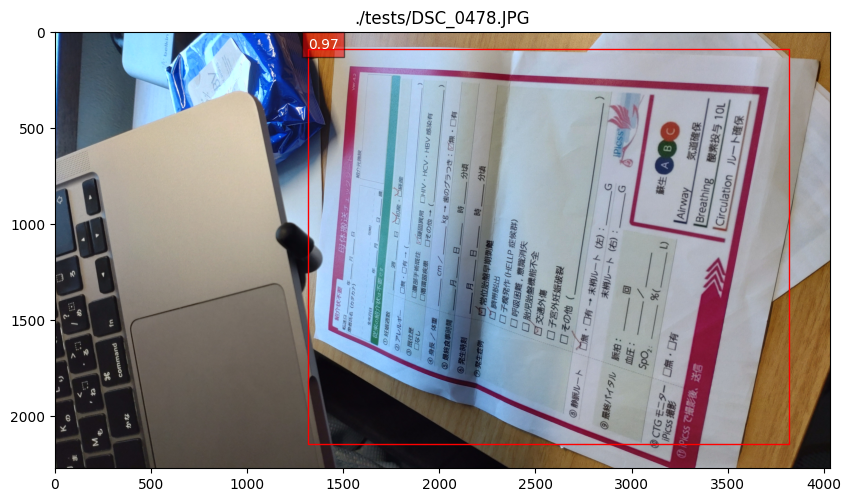

box 1625.1775


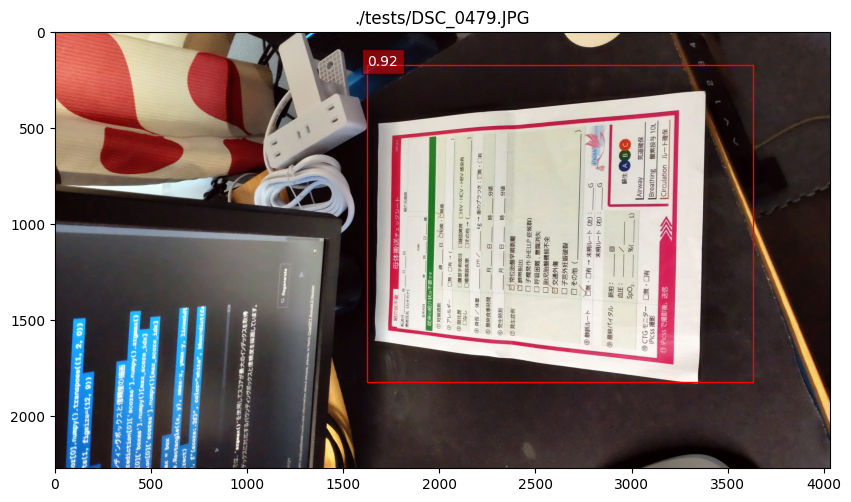

box 1118.2466


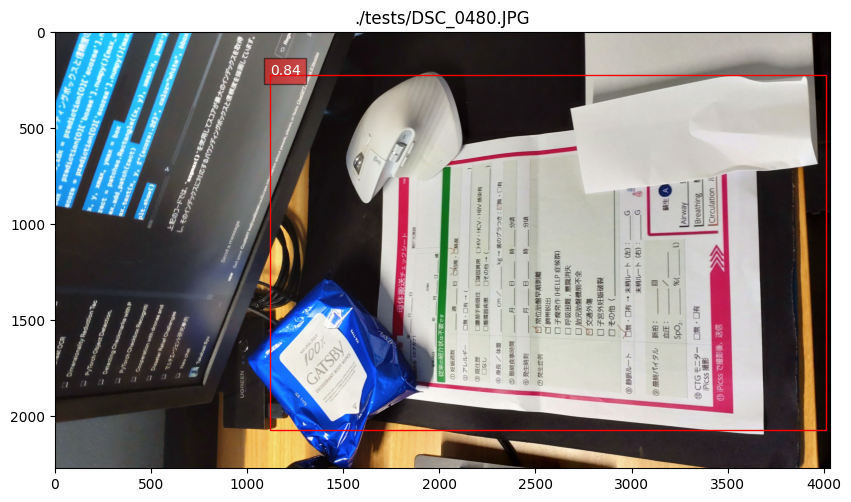

box 983.3227


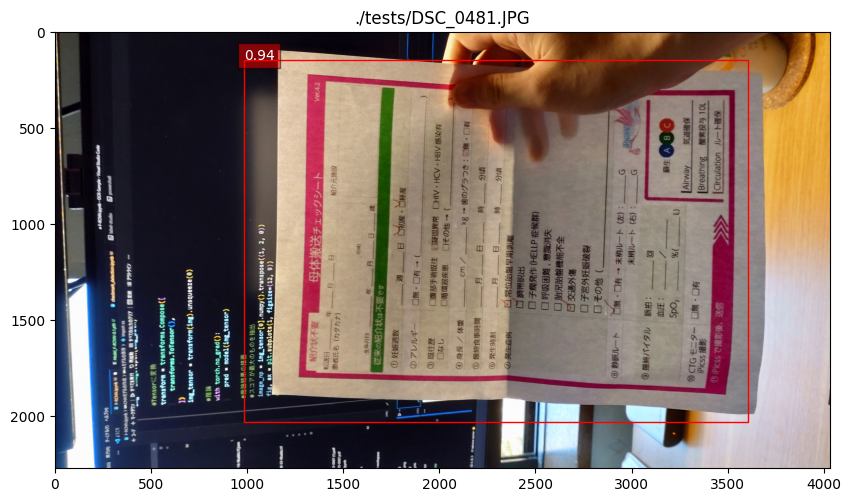

In [67]:
path1: str = "./tests/DSC_0478.JPG"
path2: str = "./tests/DSC_0479.JPG"
path3: str = "./tests/DSC_0480.JPG"
path4: str = "./tests/DSC_0481.JPG"

bbox1, img1 = prediction(path1, path1)
bbox2, img2 = prediction(path2, path2)
bbox3, img3 = prediction(path3, path3)
bbox4, img4 = prediction(path4, path4)


## 検知した紙面の切り出し＆台形補正

In [68]:
import cv2
import math

In [69]:
#画像からバウンディングボックスの領域を切り出す
def crop_bbox(img: np.ndarray[Any, Any, Any], bbox: list[tuple[int, int]]) -> np.ndarray[Any, Any, Any]:
    
    image = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    #bboxの座標を整数に変換
    x, y = bbox[0]
    xmax, ymax = bbox[2]
    x, y, xmax, ymax = int(x), int(y), int(xmax), int(ymax)
    #バウンディングボックスの領域を切り出し
    img_crop = image[y:ymax, x:xmax]
    return img_crop

def plot_img(img: np.ndarray[Any, Any, Any], plot_title: str="") -> None:
    fig, ax = plt.subplots(1, figsize=(10, 20))
    ax.imshow(img)
    ax.set_title(plot_title)
    plt.show()

In [70]:
#指定座標の台形補正を行う関数
def perspective_correction(image: list[Any], points: list[list[float]], raito: float = 1.0):
    """_summary_
    指定4点座標間の台形補正を行う
    Args:
        image (Image): 変換対象画像
        points (list[list[float]]): 変換対象を囲う4点座標
        [
            左上,
            右上,
            右下,
            左下
        ]
    """
    p1 = np.array(points[0])
    p2 = np.array(points[1])
    p3 = np.array(points[2])
    p4 = np.array(points[3])

    w_ratio = raito
    
    #　幅取得
    o_width = np.linalg.norm(p2 - p1)
    o_width = math.floor(o_width * w_ratio)
    
    #　高さ取得
    o_height = np.linalg.norm(p4 - p1)
    o_height = math.floor(o_height)
    
    # 変換前の4点
    src = np.float32([p1, p2, p4, p3])
    
    # 変換後の4点
    dst = np.float32([[0, 0],[o_width, 0],[0, o_height],[o_width, o_height]])
    
    # 変換行列
    M = cv2.getPerspectiveTransform(src, dst)
    
    # 射影変換・透視変換する
    output = cv2.warpPerspective(image, M,(o_width, o_height))

    plot_img(output, plot_title="台形補正後の画像")

    return output

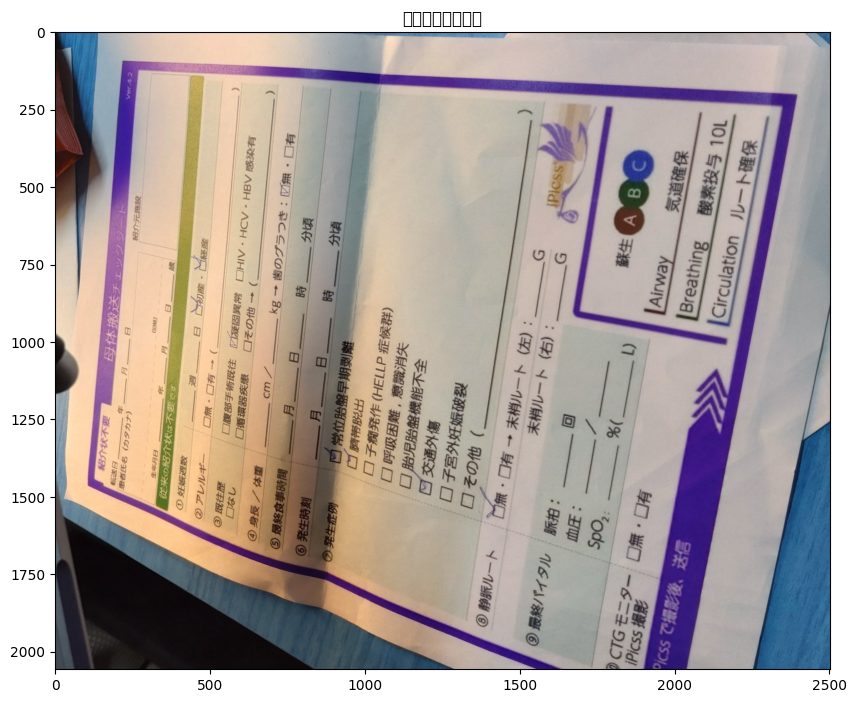

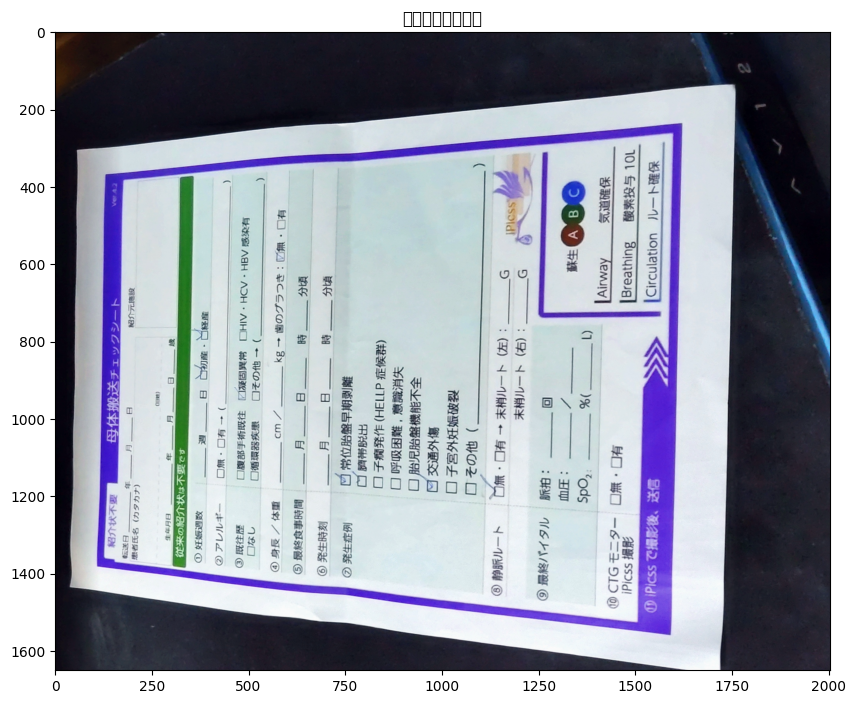

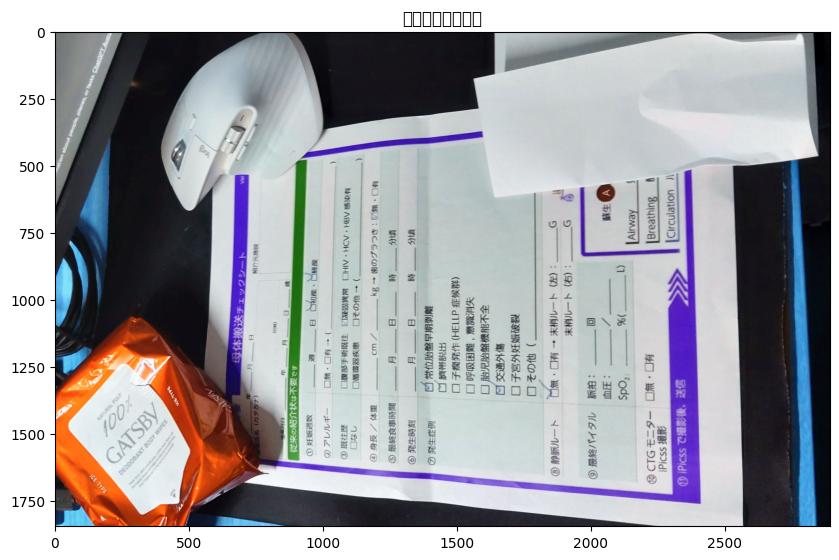

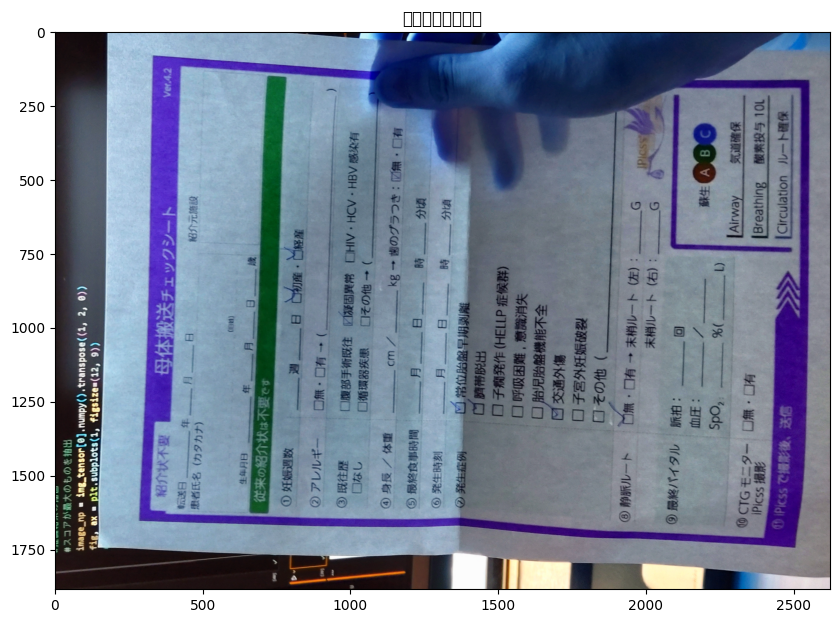

array([[[0.09419424, 0.05105698, 0.06282169],
        [0.0909084 , 0.04777114, 0.05953585],
        [0.08382353, 0.04313726, 0.05490196],
        ...,
        [0.21962316, 0.41227022, 0.59952515],
        [0.2366881 , 0.428845  , 0.61708033],
        [0.24661459, 0.43383884, 0.6314032 ]],

       [[0.08563879, 0.04250154, 0.05426624],
        [0.08786765, 0.04473039, 0.0564951 ],
        [0.08306526, 0.04237898, 0.05414369],
        ...,
        [0.22912072, 0.42176777, 0.6090227 ],
        [0.2398131 , 0.43196997, 0.6202053 ],
        [0.24045649, 0.43261337, 0.6277114 ]],

       [[0.08019301, 0.03926164, 0.05102635],
        [0.08284314, 0.04191177, 0.05367647],
        [0.07961091, 0.04044118, 0.05220588],
        ...,
        [0.22867647, 0.42132354, 0.60857844],
        [0.24385722, 0.43601415, 0.62424946],
        [0.24445467, 0.4366115 , 0.6317096 ]],

       ...,

       [[0.13908549, 0.07903646, 0.0748698 ],
        [0.1423943 , 0.0796492 , 0.08357078],
        [0.13491882, 0

In [71]:
image1 = cv2.cvtColor(img1, cv2.COLOR_RGB2BGR)
image2 = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)
image3 = cv2.cvtColor(img3, cv2.COLOR_RGB2BGR)
image4 = cv2.cvtColor(img4, cv2.COLOR_RGB2BGR)

perspective_correction(image1, bbox1)
perspective_correction(image2, bbox2)
perspective_correction(image3, bbox3)
perspective_correction(image4, bbox4)